# Part 1
## Clean Text Data and Construct Document Term Matrix
### Run this section first and then you can run any other section in this notebook

In [2]:
import pandas
import os
wd = os.getcwd()

## Read in Review Files and create a pandas dataframe (code borrowed from Julian McAuley website) ##
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

food_review = getDF(os.path.join(wd,"..","data/raw/reviews_Grocery_and_Gourmet_Food_5.json.gz"))

In [3]:
##Miki's code for merging metadata
metadata = getDF('../data/raw/meta_Grocery_and_Gourmet_Food.json.gz')
metadata['categories'] = metadata['categories'].apply(str)
metadata_col_subset = metadata.drop(['imUrl', 'related'],1)
full_df = pd.merge(food_review, metadata_col_subset, how = "left", on = ["asin"])

In [4]:
##Call in data that includes UPC/ASINs from original press release data
recall_data = pandas.read_csv(os.path.join(wd,"..","data/processed/recalls_upcs_asins_joined.csv"), index_col=0,
                              encoding='ISO-8859-1')

In [5]:
##Pull in recall dates based on ASIN matching
row_iterator = full_df.iterrows()
recall_dates = []

for index, row in row_iterator:
    asin = row['asin']
    row_count = -1
    recall_date = ""
    for asin_list in recall_data['asins']:
        row_count += 1
        if isinstance(asin_list, str):
            if asin in asin_list:
                recall_date = recall_data.DATE[row_count]
    recall_dates.append(recall_date)

In [6]:
##Create Recall Date DataFrame and append it to food_review_dataset
recall_date_df = pandas.DataFrame(recall_dates, columns=['Recall_date'])

In [7]:
##Combine Recall Date DataFrame with overall recall dataframe
combined_df = pandas.concat([full_df, recall_date_df], axis=1)

In [8]:
##Format Dates to match
combined_df['unixReviewTime'] = pandas.to_datetime(combined_df['unixReviewTime'], unit='s').dt.date
combined_df['Recall_date'] = pandas.to_datetime(combined_df['Recall_date'], unit='s').dt.date

In [9]:
##Add Date bounderies
combined_df['Recall_date_plus1Y'] = pandas.to_datetime(combined_df['Recall_date'] + pandas.DateOffset(years=1)).dt.date
combined_df['Recall_date_minus1Y'] = pandas.to_datetime(combined_df['Recall_date'] - pandas.DateOffset(years=1)).dt.date

In [10]:
##Define recall to have recall date and review be within a year of the recall
combined_df['recalled'] = (((combined_df['unixReviewTime'] < combined_df['Recall_date_plus1Y']) == True)\
                             & ((combined_df['unixReviewTime'] > combined_df['Recall_date_minus1Y']) == True)).astype('int')

In [23]:
##Subset data
combined_df_subset = combined_df.loc[0:20000,:]

In [24]:
##Test to see how many recalled are in the subset
len(combined_df_subset[combined_df_subset.recalled == 1])

0

In [25]:
##Add all recalled to data above
combined_df_recalled = combined_df[combined_df.recalled == 1]
combined_df_subset = pd.concat([combined_df_subset, combined_df_recalled], axis=0)
combined_df_subset = combined_df_subset.reset_index(drop=True)
len(combined_df_subset)

20071

In [28]:
##Tokenize review text for each review
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()

combined_df_subset['reviewText'] = combined_df_subset['reviewText'].str.replace("'", "")
combined_df_subset['reviewText'] = combined_df_subset['reviewText'].str.replace('[^a-zA-Z\s]',' ')
tokens_I = [word_tokenize(review) for review in combined_df_subset['reviewText']]

In [29]:
##Separate strings with multiple uppercase characters (e.g., gCholesterol, VeronaStarbucks). This should (hopefully)
## take care of situations where the reviews included returns that were not treated as spaces in the raw text file
import re
def split_uppercase(tokens):
    tokens_II = np.empty((len(tokens),0)).tolist()
    for review in tokens:
        n = tokens.index(review)
        for word in review:
            split = re.sub(r'([A-Z][a-z])', r' \1', word)
            tokens_II[n].append(split)
    return tokens_II

tokens_II = split_uppercase(tokens_I)

In [30]:
##Make all text lower case
def make_lowercase(tokens):
    tokens_final = np.empty((len(tokens),0)).tolist()
    for review in tokens:
        n = tokens.index(review)
        for word in review:
            lowercase_word = word.lower()
            tokens_final[n].append(lowercase_word)
    return tokens_final

tokens = make_lowercase(tokens_II)

In [31]:
##Remove stopwords and stem
stopwords = stopwords.words('english')

def stem_tokens(tokens):
    stemmed_token = np.empty((len(tokens),0)).tolist()
    for review in tokens:
        n = tokens.index(review)
        for word in review:
            if word not in stopwords:
                stem = st.stem(word)
                stemmed_token[n].append(stem)
    return stemmed_token
        
stemmed = stem_tokens(tokens)

In [32]:
##Manipulate stemmed text to be string instead of list (needed for count vectorizer)
def make_string(text):
    final_review_text = []
    for review in text:
        for word in review:
            n = review.index(word)
            if n == 0:
                string = review[n]
            else:
                string = string + " " + review[n]
        final_review_text.append(string)
    return final_review_text

final_text = make_string(stemmed)

In [33]:
##Count Vectorizer Matrix
import numpy as np
import scipy
from scipy.sparse import csr_matrix, vstack, hstack
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=False, ngram_range=(1, 1)) ##Removed stopwords before stemming so don't apply here
food_review_text = vectorizer.fit_transform(final_text)

##Remove if word is in less than 5 reviews - Uncomment if want to do this 

#counts = scipy.sparse.csr_matrix.sum(food_review_text, axis=0)
#food_review_text = np.transpose(vstack([food_review_text,counts]))
#food_review_text = pd.DataFrame(food_review_text.todense(), index = vectorizer.get_feature_names())

#last_col = food_review_text.shape[1] - 1
#food_review_text = food_review_text[food_review_text[last_col] > 4]
#del food_review_text[last_col]

In [34]:
##TFIDF Weighting
from sklearn.feature_extraction.text import TfidfTransformer
#food_review_text = food_review_text.transpose()

transformer = TfidfTransformer()
tfidf_matrix = transformer.fit_transform(food_review_text)

In [18]:
##create dummy variables for categories and append to Dataset - Uncomment if want to do this
#category_df = combined_df_subset['categories'].str.get_dummies()
#category_sparse = scipy.sparse.csr_matrix(category_df.values)
#from scipy.sparse import hstack
#food_category_matrix = hstack([tfidf_matrix, category_sparse])

# Part 2
## Linear SVM Analysis

In [35]:
##Generic SVM analysis
from sklearn.svm import LinearSVC

recall = combined_df_subset['recalled']
model = LinearSVC(C=1)
results = model.fit(tfidf_matrix, recall)

In [36]:
term_names = vectorizer.get_feature_names()
term_names = pd.DataFrame(term_names)
#term_names = pd.DataFrame(food_review_text.columns.values)
#cat_names = pd.DataFrame(category_df.columns.values)
#X_col_names = pd.concat([term_names,cat_names], axis=0)
#X_col_names = X_col_names.reset_index(drop=True)

results_coef = results.coef_
results_coef_array = np.transpose(np.asarray(results_coef, dtype=np.float32))
results_df_coef = pd.DataFrame(results_coef_array, columns=['Coef'], dtype=float)
results_dataframe = pd.concat([term_names, results_df_coef], axis=1)

In [37]:
results_dataframe = results_dataframe.sort_values(by='Coef', ascending=False)

In [38]:
results_dataframe

,0,Coef
8323,justins,2.211690
6782,guav,1.852160
5157,evalu,1.285161
5475,fda,1.245542
14721,spreads,1.231661
17145,vitacoco,1.099067
6858,gym,1.086995
6639,grapenuts,1.070981
4151,devil,1.029541
7201,hershey,1.011778


In [39]:
results_dataframe[(results_dataframe[0] == 'sick') == True]

,0,Coef
14080,sick,0.382883


In [40]:
combined_df_subset_recall = combined_df_subset[combined_df_subset['recalled'] == 1]

In [41]:
combined_df_subset_recall.groupby(['asin'])['reviewerID'].count()

asin
B000H23Z1C     1
B000H2998U     2
B000LKU874     3
B000LKYX48     1
B000UUWECC    24
B0012690UC     6
B001E4Q5WI     3
B001HTGAQQ     1
B001VNGMDE     5
B00555H0LC    11
B005M4AM5M     3
B006R7F0PU     4
B00B044BNW     6
Name: reviewerID, dtype: int64

In [42]:
combined_df_subset_recall[combined_df_subset_recall.asin == 'B000UUWECC']

,reviewerName,reviewTime,reviewText,reviewerID,overall,summary,helpful,unixReviewTime,asin,description,categories,title,salesRank,price,brand,Recall_date,Recall_date_plus1Y,Recall_date_minus1Y,recalled
20008,ai chan1,"03 19, 2011",During my childhood till my teen years we had...,AOTMAME2XYZ65,3.0,Not Bad at All but,"[1, 1]",2011-03-19,B000UUWECC,"O.N.E.&#8482; is 100% natural coconut water, w...",[['Grocery & Gourmet Food']],"O.N.E. Coconut Water, 11.2-Ounce Aseptic Conta...",{'Grocery & Gourmet Food': 17418},32.99,NaN,2011-03-12,2012-03-12,2010-03-12,1
20009,Amazon Customer,"12 17, 2011",So looking forward to drinking coconut wa...,A3DNVDSLESKN3D,1.0,Beware!,"[2, 2]",2011-12-17,B000UUWECC,"O.N.E.&#8482; is 100% natural coconut water, w...",[['Grocery & Gourmet Food']],"O.N.E. Coconut Water, 11.2-Ounce Aseptic Conta...",{'Grocery & Gourmet Food': 17418},32.99,NaN,2011-03-12,2012-03-12,2010-03-12,1
20010,"Amazon Customer ""Rio""","09 11, 2010",hi every one I just wanted to share some of my...,A2690VEUY5C6WV,3.0,Not as healthy as you would think,"[4, 7]",2010-09-11,B000UUWECC,"O.N.E.&#8482; is 100% natural coconut water, w...",[['Grocery & Gourmet Food']],"O.N.E. Coconut Water, 11.2-Ounce Aseptic Conta...",{'Grocery & Gourmet Food': 17418},32.99,NaN,2011-03-12,2012-03-12,2010-03-12,1
20011,Andrew Remington Fox,"02 25, 2012",I have tried Zico Naked Vita Coco and O N E...,AZ0Z7TEMQYJMB,5.0,Best Coconut Water so far..,"[0, 0]",2012-02-25,B000UUWECC,"O.N.E.&#8482; is 100% natural coconut water, w...",[['Grocery & Gourmet Food']],"O.N.E. Coconut Water, 11.2-Ounce Aseptic Conta...",{'Grocery & Gourmet Food': 17418},32.99,NaN,2011-03-12,2012-03-12,2010-03-12,1
20012,"B. Santos ""bikram_mom_18""","03 12, 2011",I thought something was very off then I did s...,A1G9EZSK3QC0UI,1.0,**WARNING-recalled by the FDA!**,"[0, 7]",2011-03-12,B000UUWECC,"O.N.E.&#8482; is 100% natural coconut water, w...",[['Grocery & Gourmet Food']],"O.N.E. Coconut Water, 11.2-Ounce Aseptic Conta...",{'Grocery & Gourmet Food': 17418},32.99,NaN,2011-03-12,2012-03-12,2010-03-12,1
20013,Charlemange,"03 13, 2010",This was a nice drink It tasted like coconut...,A1DH3QDZX8Z7GO,4.0,Not bad at all,"[0, 2]",2010-03-13,B000UUWECC,"O.N.E.&#8482; is 100% natural coconut water, w...",[['Grocery & Gourmet Food']],"O.N.E. Coconut Water, 11.2-Ounce Aseptic Conta...",{'Grocery & Gourmet Food': 17418},32.99,NaN,2011-03-12,2012-03-12,2010-03-12,1
20014,"Clear Blue ""clearblue""","07 26, 2010",Why did Amazon stop stocking this Now it is s...,A36737X1HKU0FQ,5.0,The best Coconut water I've found on Amazon,"[1, 1]",2010-07-26,B000UUWECC,"O.N.E.&#8482; is 100% natural coconut water, w...",[['Grocery & Gourmet Food']],"O.N.E. Coconut Water, 11.2-Ounce Aseptic Conta...",{'Grocery & Gourmet Food': 17418},32.99,NaN,2011-03-12,2012-03-12,2010-03-12,1
20015,Colene M. White,"07 27, 2010",Ive really enjoyed the taste of this Coconut W...,A1KJDOL79GJ3JI,5.0,This one is my favorite!,"[0, 0]",2010-07-27,B000UUWECC,"O.N.E.&#8482; is 100% natural coconut water, w...",[['Grocery & Gourmet Food']],"O.N.E. Coconut Water, 11.2-Ounce Aseptic Conta...",{'Grocery & Gourmet Food': 17418},32.99,NaN,2011-03-12,2012-03-12,2010-03-12,1
20016,Honestly,"05 16, 2011",have been buying this product for three years ...,A3EIOMC103PG7W,1.0,soap water,"[0, 0]",2011-05-16,B000UUWECC,"O.N.E.&#8482; is 100% natural coconut water, w...",[['Grocery & Gourmet Food']],"O.N.E. Coconut Water, 11.2-Ounce Aseptic Conta...",{'Grocery & Gourmet Food': 17418},32.99,NaN,2011-03-12,2012-03-12,2010-03-12,1
20017,jahken,"04 6, 2011",The ONE coconut water is the best coconut wate...,A1QFGPNAF9M9CZ,4.0,A Yard mon should know,"[0, 0]",2011-04-06,B000UUWECC,"O.N.E.&#8482; is 100% natural coconut water, w...",[['Grocery & Gourmet Food']],"O.N.E. Coconut Water, 11.2-Ounce Aseptic Conta...",{'Grocery & Gourmet Food': 17418},32.99,NaN,2011-03-12,2012-03-12,2010-03-12,1


# Part 3
## LASSO Analysis

In [99]:
##Lasso
from sklearn.linear_model import lasso_path
alphas, coef_path, _ = lasso_path(tfidf_matrix, recall, alphas=[1e-03,1e-04,4e-05])
#model_2 = lasso_path(alpha=2e-05)
#results_2 = model_2.fit(tfidf_matrix, recall)

In [ ]:
term_names = vectorizer.get_feature_names()
term_names = pd.DataFrame(term_names)

In [100]:
results2_coef_array = (np.asarray(coef_path, dtype=np.float32))
results2_coef_df = pd.DataFrame(results2_coef_array, columns=['a = 1e-03','a = 1e-04', 'a = 4e-05'], dtype=float)
results2_dataframe = pd.concat([term_names, results2_coef_df], axis=1)

In [101]:
results2_dataframe_keep = results2_dataframe[(results2_dataframe['a = 1e-03'] > 0) | (results2_dataframe['a = 1e-04'] > 0) \
                                             |(results2_dataframe['a = 4e-05'] > 0)]
results2_dataframe_keep

,0,a = 1e-03,a = 1e-04,a = 4e-05
1777,box,0.0,0.000000,0.002696
2079,but,0.0,0.000000,0.013336
2105,buy,0.0,0.000000,0.001739
3027,coconut,0.0,0.076265,0.091793
4602,drink,0.0,0.000000,0.013272
5439,fat,0.0,0.000000,0.006831
6198,garl,0.0,0.000000,0.053061
6782,guav,0.0,0.000000,0.752886
7050,hazelnut,0.0,0.000000,0.035353
7385,hop,0.0,0.000000,0.008438


# Part 4
## Unsupervised NMF first, Supervised learning second

In [104]:
## Non-negative matrix factorization
import nimfa

tfidf_matrix_nmf = np.transpose(tfidf_matrix)
nmf = nimfa.Nmf(tfidf_matrix_nmf, rank=30, seed='random_c', update="divergence", objective="div")
fit = nmf()

/Applications/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


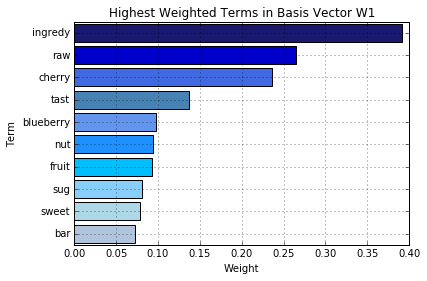

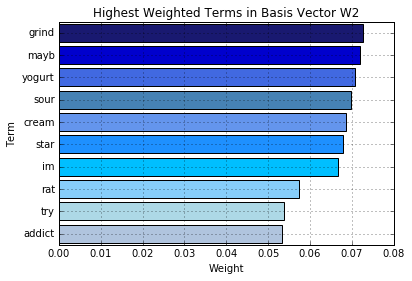

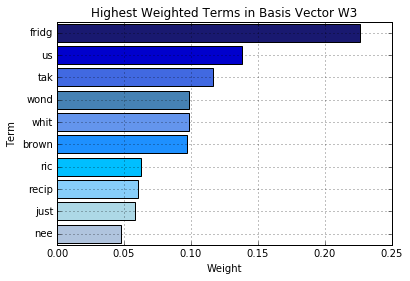

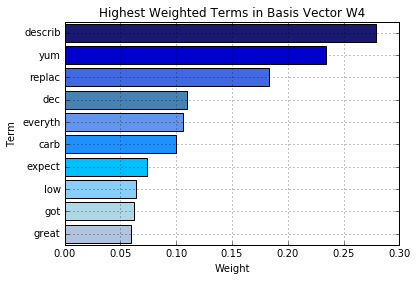

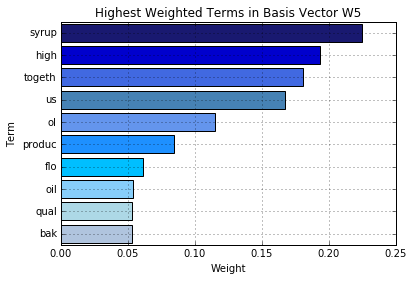

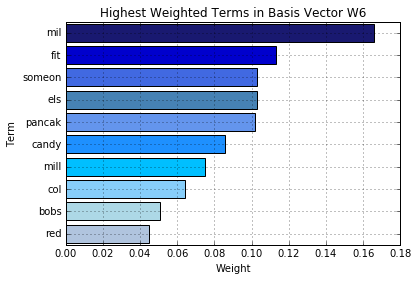

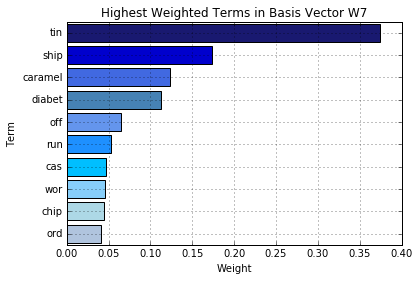

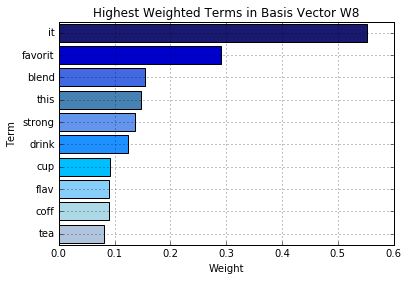

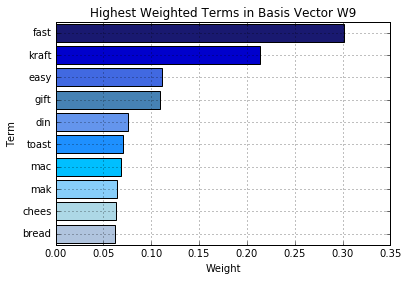

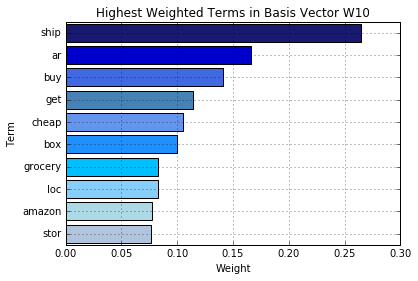

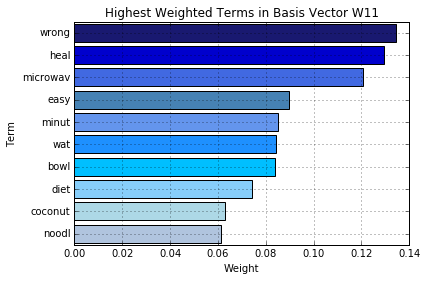

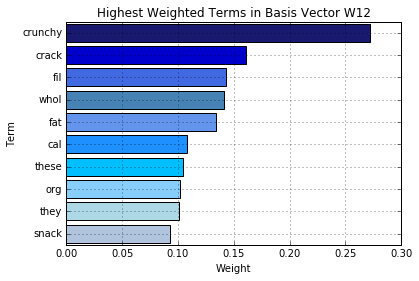

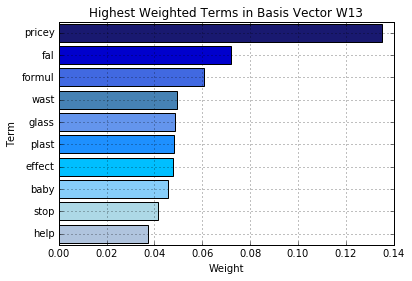

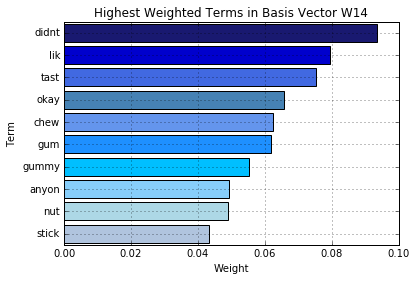

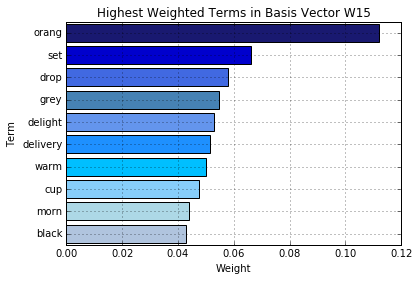

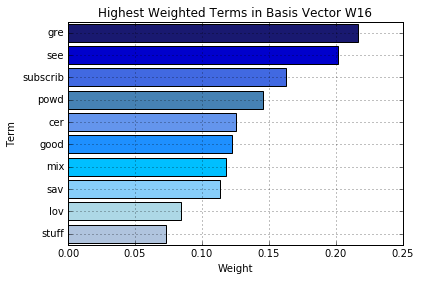

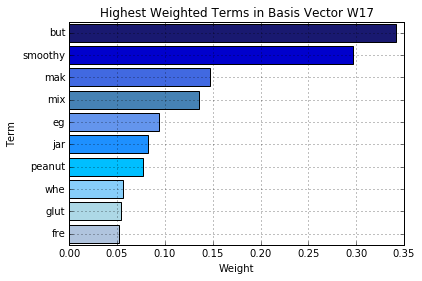

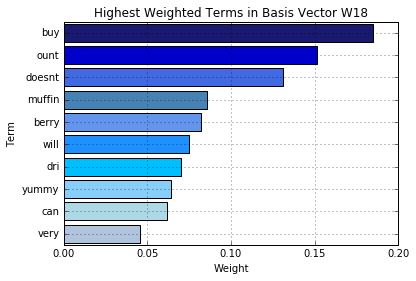

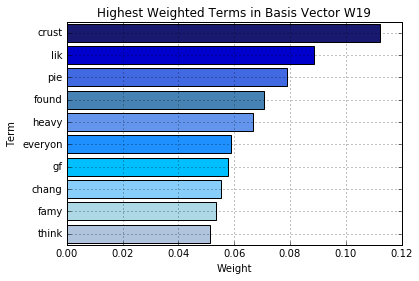

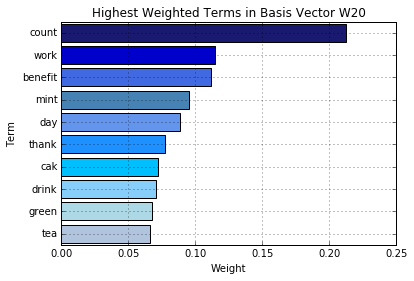

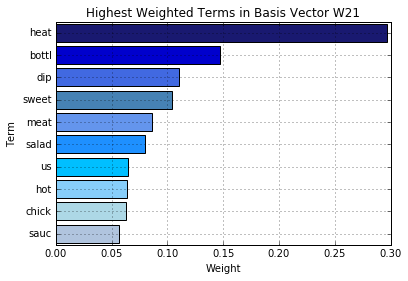

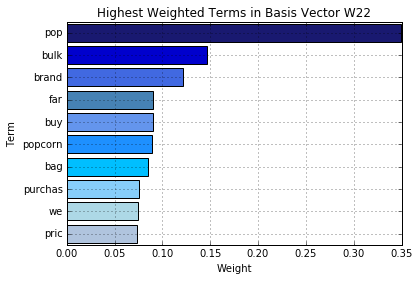

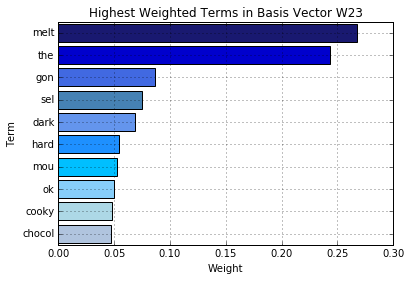

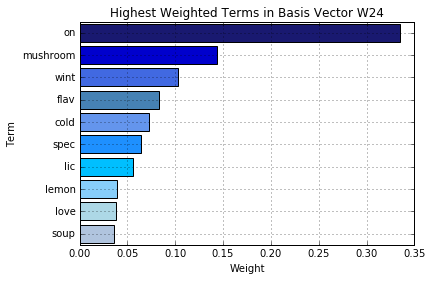

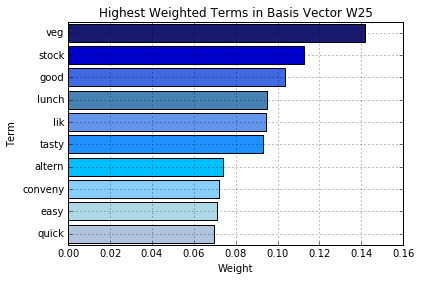

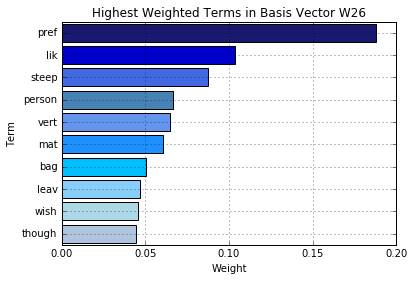

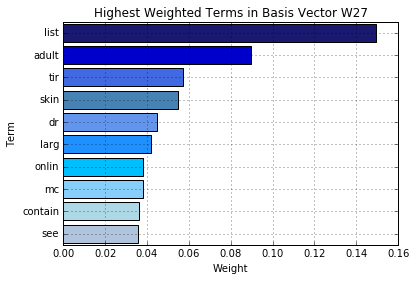

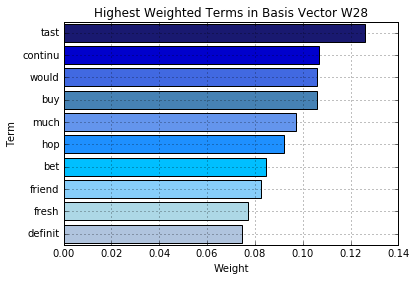

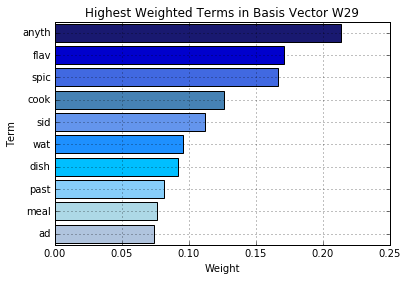

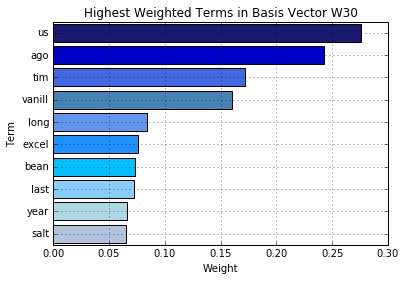

In [117]:
##Check out 
feature_names = vectorizer.get_feature_names()
import matplotlib.pylab as plb
%matplotlib inline

def plot(W,termlist):
    for c in range(W.shape[1]):
        top10 = np.argsort(np.asarray(W[:,c].todense()).flatten())[-10:]
        val = W[top10, c].todense()
        plb.figure(c + 1)
        plb.barh(np.arange(10) + .5, val, color=['LightSteelBlue', 'LightBlue', 'LightSkyBlue', 'DeepSkyBlue', 'DodgerBlue', 
                                                 'CornflowerBlue','SteelBlue','RoyalBlue','MediumBlue', 'MidnightBlue'], align='center')
        plb.yticks(np.arange(10) + .5, [feature_names[i] for i in top10][::-1])
        plb.xlabel("Weight")
        plb.ylabel("Term")
        plb.title("Highest Weighted Terms in Basis Vector W%d" % (c + 1))
        plb.grid(True)
    
plot(fit.basis(), feature_names)

In [124]:
##Generic SVM analysis using lower dimensions from topic modeling
from sklearn.svm import LinearSVC

recall = combined_df_subset['recalled']
H = np.transpose(fit.coef())

model = LinearSVC(C=1)
results = model.fit(H, recall)

In [129]:
results_coef_array = np.transpose(np.asarray(results.coef(), dtype=np.float32))
results_df_coef = pd.DataFrame(results_coef_array, columns=['Coef'], dtype=float)
results_df_coef = results_df_coef.sort_values(by='Coef', ascending=False)
results_df_coef

,Coef
10,0.022880
25,0.015946
21,0.005649
26,0.004948
1,0.002577
4,0.001984
28,0.001541
9,0.001165
15,0.000153
18,-0.002941


In [133]:
##Lasso
from sklearn.linear_model import lasso_path
alphas, coef_path, _ = lasso_path(H, recall, alphas=[1e-03,1e-04,4e-05])


results3_coef_array = (np.asarray(coef_path, dtype=np.float32))
results3_coef_df = pd.DataFrame(results3_coef_array, columns=['a = 1e-03','a = 1e-04', 'a = 4e-05'], dtype=float)

results3_coef_df

,a = 1e-03,a = 1e-04,a = 4e-05
0,0.0,0.000000,0.000000
1,0.0,0.000000,0.001939
2,0.0,0.000000,0.000000
3,0.0,0.000000,0.000000
4,0.0,0.000000,0.002392
5,0.0,0.000000,-0.000000
6,0.0,0.000000,0.000000
7,0.0,0.000000,0.000000
8,0.0,0.000000,0.000375
9,0.0,0.004351,0.006640
